In [1]:
## Distributed python packages
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

from math import radians, log
from sys import exit

##Own librairies
from readWW31 import read_dpt
from read_hs_p2l import read_hs, read_p2l
from subfunctions_source_DF import loop_ww3_sources, download_ww3_local, download_ww3_local, open_bathy, ampli

__author__ = "Lisa Tomasetto"
__copyright__ = "Copyright 2024, UGA"
__credits__ = ["Lisa Tomasetto"]
__version__ = "1.0"
__maintainer__ = "Lisa Tomasetto"
__email__ = "lisa.tomasetto@univ-grenoble-alpes.fr"
__status__ = "Production"

# Secondary Microseisms Sources of Ambient Noise

This Jupyter Notebook aims at modelizing ambient noise sources in the secondary microseismic band, i.e. from 3s to 12s of period.
We will compute the equivalent vertical force $\text{F}$ applied at the seafloor in $\text{N}.\text{s}^{1/2}$. We use oceanic hindcast WAVEWATCHIII data for this modelization.

$ F(f_s) = 2\pi \sqrt{\int_{-\pi/2}^{\pi/2} \int_0^{2\pi} \int_{f_{min}}^{f_{max}} c_{P/S}^2(\lambda', \phi', f_s) F_{p3D}(k_2 \approx 0, f_s) R_E^2sin\phi'd\lambda'd\phi' df}$

where:
- $f_s$ is the seismic frequency in Hz (twice the ocean wave frequency)
- $f_{min}$ and $f_{max}$, the lower and upper frequency bounds.
- $c_{P/S}$ the amplification coefficients for P or S waves, from Gualtieri et al. (2014).
- $F_{p3D}(k_2 \approx 0, f_s)$ the spectral density of the pressure field at the ocean surface or directional wave spectra in $\text{Pa}^2.\text{m}^2.\text{s}.$
- $R_E$ the Earth's radius
- $\lambda'$ the latitude and $\phi'$ the longitude

In our case we will focus on the period band $T \in [3, 10]$s, where body waves can be retrieved. So our maps will be integrated from $f_{min}=0.1 \text{ Hz}$ to $f_{max}=0.3 \text{ Hz}$. 

#### References
* L. Gualtieri, E. Stutzmann, V. Farra, Y. Capdeville, M. Schimmel, F. Ardhuin, A. Morelli, Modelling the ocean site effect on seismic noise body waves, Geophysical Journal International, Volume 197, Issue 2, May 2014, Pages 1096–1106, https://doi-org.insu.bib.cnrs.fr/10.1093/gji/ggu042
* Boué, P., & Tomasetto, L. (2024). Opportune detections of global P-wave propagation from microseisms interferometry. Comptes Rendus. Géoscience, 356(S4), 1-16.
* The WAVEWATCH III® Development Group (WW3DG), 2019: User manual and system documentation of WAVEWATCH III® version 6.07. Tech. Note 333, NOAA/NWS/NCEP/MMAB, College Park, MD, USA, 326 pp. + Appendices.

## Parameters
This implementation depends on a few parameters, some are described in the above formula but some are for the user to choose.
### Physical Constants
Default values are given below, please change with your own if needed.


In [2]:
F1 = 1/10  # frequency lower bound
F2 = 1/3  # frequency upper bound
wave_type = 'P'  # 'P' or 'S'
parameters = [F1, F2]

## Dates
Then the dates the user wants to focus on, loops on hours, days, months and years are available setting an empty bracket symbol '[]'.

In [3]:
YEAR = 2014  # year of interest
MONTH = [1]  # loop if array, compute all months of the year if empty list []
DAY = []  # loop if array, compute all days of the month if empty list []
HOUR = []  # loop if array, compute every 3 hours of the day if empty list []

date_vec = [YEAR, MONTH, DAY, HOUR]

## Spatial Extent

In [4]:
lat_min = -78 # -78 min
lat_max = 80 # 80 max
lon_min = -180 # -180 min
lon_max = 180 # 180 max

extent = [lon_min, lon_max, lat_min, lat_max]

## Paths to Files

In [5]:
# ftp path of WW3 data
ftp_path_to_files = "ftp://ftp.ifremer.fr/ifremer/dataref/ww3/GLOBMULTI_ERA5_GLOBCUR_01/GLOB-30M/%d/FIELD_NC/"%YEAR

# local path for WW3 data
ww3_local_path = "/Volumes/LaCie/data/%d/"%YEAR  # path where the data will be downloaded

# bathymetry default
file_bathy = "./ww3.07121700.dpt"  #0.5x0.5 degree grid bathymetry

paths = [file_bathy, ww3_local_path]

## Download WW3 Files
For the model files go to ftp://ftp.ifremer.fr/ifremer/dataref/ww3/GLOBMULTI_ERA5_GLOBCUR_01/GLOB-30M/, then choose the year(s) and month(s) corresponding files. We download the directional wave spectra file, extension p2l.nc (default).
If you want to download the full output of WW3 set ```full = True``` 
It will download a .nc file containing the full output of WW3 (including significant waveheight Hs).

In [6]:
download_ww3_local(YEAR, MONTH, ftp_path_to_files, ww3_local_path)

/Users/tomasetl/GITLAB/terracor/NOTEBOOKS/BODY_WAVES
[Errno 17] File exists: './data/'

ftp://ftp.ifremer.fr/ifremer/dataref/ww3/GLOBMULTI_ERA5_GLOBCUR_01/GLOB-30M/2014/FIELD_NC/LOPS_WW3-GLOB-30M_201401_p2l.nc
-----------------------------------------------------------------

/Volumes/LaCie/data/2014/LOPS_WW3-GLOB-30M_201401_p2l.nc already downloaded

-----------------------------------------------------------------

WW3 files downloaded in /Volumes/LaCie/data/2014/
current directory :  /Users/tomasetl/GITLAB/terracor/NOTEBOOKS/BODY_WAVES


In [7]:
dpt1, zlon, zlat = open_bathy(file_bathy, refined_bathymetry=False, extent=extent)

 dpt1 shape  (317, 720)


### Save and Plot
If you want to save the 3-hourly matrix as a netcdf file set the save variable to True.
```save = True ```

If you want to plot the maps and save them as .png files set the plot_type variable to:
* ```plot_type = 'hourly'``` for plots every 3-hours (WW3 resolution)
* ```plot_type = 'daily'``` for summed daily plots
* ```plot_type = 'monthly'``` for summed monthly plots
* ```plot_type = 'yearly'``` for summed yearly plots

In [8]:
save = False  # save matrix as netcdf
plot_type = 'hourly' # plot Force 'hourly', 'daily', 'monthly', 'yearly'

## Main Loop

File WW3  /Volumes/LaCie/data/2014//LOPS_WW3-GLOB-30M_201401_p2l.nc


KeyboardInterrupt: 

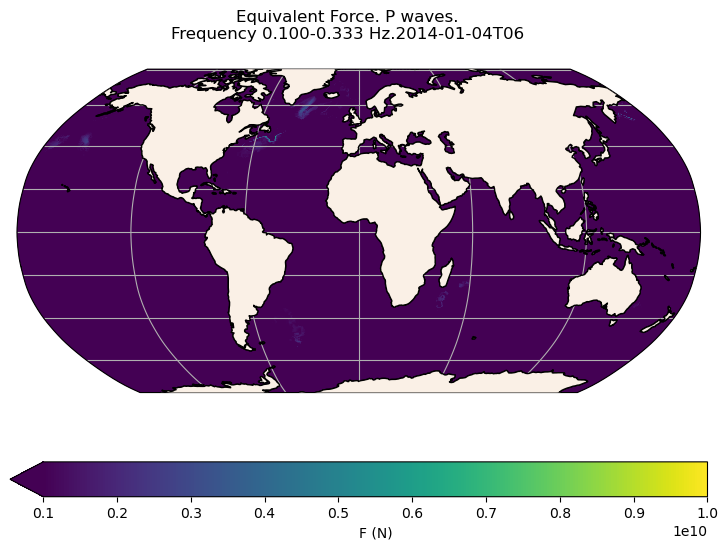

In [12]:
loop_ww3_sources(paths, dpt1, zlon, zlat,
                 wave_type = wave_type,
                 date_vec = date_vec, extent = extent, parameters = parameters, 
                 plot_type = plot_type, save = save, vmin = 0, vmax = 1e10)